# Task 3: Super-Resolution with Implicit Neural Representations

In this notebook, we'll perform 2x super-resolution. The core idea is to learn a continuous function, an "Implicit Neural Representation," of an image from its low-resolution version. Since this function is continuous, we can then sample from it at a higher resolution to generate new detail.

### The Workflow

1.  **Start with a high-resolution (HR) "ground truth" image.** For our task, this will be `400x400`.
2.  **Create the low-resolution (LR) input.** We downsample the HR image by a factor of 2 to get a `200x200` image.
3.  **Train the model.** We train our `SignalMLP` on the LR image. The model learns a function that maps the `(y, x)` coordinates of the LR image to its RGB pixel values. Crucially, the coordinates are normalized to a continuous `[-1, 1]` space.
4.  **Perform Inference (Super-Resolve).** We create a new, dense coordinate grid for the target `400x400` resolution. We pass these HR coordinates through our trained model to predict the pixel values for the super-resolved image.
5.  **Evaluate.** We compare our predicted `400x400` image to the original ground truth HR image using RMSE and PSNR metrics.

In [1]:
import torch
import numpy as np
import sys
import os
from torchvision.transforms.functional import center_crop

# Add the src directory to the Python path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

# Import our custom modules, now using RFFEncoder
from data_loader import load_image, downsample_image
from models import SignalMLP
from training import train_rff_model
from utils import (
    create_coordinate_map, 
    get_pixels_from_image, 
    RFFEncoder, # <-- Corrected import
    calculate_image_metrics,
)
from visualize import plot_super_resolution

# Setup device
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

/Users/devanshlodha/Documents/github/signal-synth-ml/signal-synth-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: mps


## 1. Data Preparation

We load a high-resolution image and create our low-resolution training sample.

In [2]:
# --- 1. Load Ground Truth HR Image ---
IMG_PATH = '../data/images/dog.jpg'
original_image = load_image(IMG_PATH, device)

# Create a 400x400 crop to serve as our High-Resolution ground truth
hr_ground_truth = center_crop(original_image, output_size=[400, 400])

# --- 2. Create Low-Resolution Training Input ---
# Downsample by a factor of 2 to create the 200x200 LR image
SCALE_FACTOR = 2
lr_input_image = downsample_image(hr_ground_truth, scale_factor=SCALE_FACTOR)

print(f"Ground Truth HR image shape: {hr_ground_truth.shape}")
print(f"Training LR input image shape: {lr_input_image.shape}")

Ground Truth HR image shape: torch.Size([3, 400, 400])
Training LR input image shape: torch.Size([3, 200, 200])


## 2. Model Training

We train our `SignalMLP` using the low-resolution image. The model will only ever "see" the `200x200` data.

In [3]:
# --- 1. Prepare Training Data from LR Image ---
lr_coords = create_coordinate_map(lr_input_image.shape[1], lr_input_image.shape[2], device)
lr_pixels = get_pixels_from_image(lr_input_image)

# --- 2. Define Hyperparameters ---
SR_SCALES = [4.0, 16.0, 64.0] 
SR_MAPPING_SIZE_PER_SCALE = 1024
SR_MLP_HIDDEN = 256
SR_MLP_LAYERS = 4
SR_EPOCHS = 5000
SR_LR = 1e-4

# --- 3. Create a Stateful RFF Encoder ---
# This encoder will generate one set of random matrices and reuse them.
rff_encoder = RFFEncoder(
    d_in=2, # 2D coordinates
    mapping_size_per_scale=SR_MAPPING_SIZE_PER_SCALE,
    scales=SR_SCALES,
    device=device
)

# Encode the low-resolution coordinates
print("Encoding LR image coordinates...")
lr_rff_features = rff_encoder.encode(lr_coords)

# --- 4. Create and Train the Model ---
sr_model = SignalMLP(
    in_features=rff_encoder.d_out,
    out_features=3, # RGB
    hidden_features=SR_MLP_HIDDEN,
    num_hidden_layers=SR_MLP_LAYERS
)

print("Training Super-Resolution model on LR data...")
# The MLP output is tanh, so we scale target pixels from [0, 1] to [-1, 1]
train_rff_model(sr_model, lr_rff_features, lr_pixels * 2 - 1, SR_EPOCHS, SR_LR, device)

Encoding LR image coordinates...
Training Super-Resolution model on LR data...


Training RFF Model: 100%|██████████| 5000/5000 [19:39<00:00,  4.24it/s, loss=0.000002]


## 3. Inference and Evaluation

Now we use the **same encoder** that was used for training to encode the high-resolution coordinate grid. This ensures the feature space is consistent and the model can generalize correctly.

Encoding HR image coordinates with the *same* encoder...
Performing inference to generate SR image...

Super-Resolution Metrics -> RMSE: 0.0323, PSNR: 29.81 dB


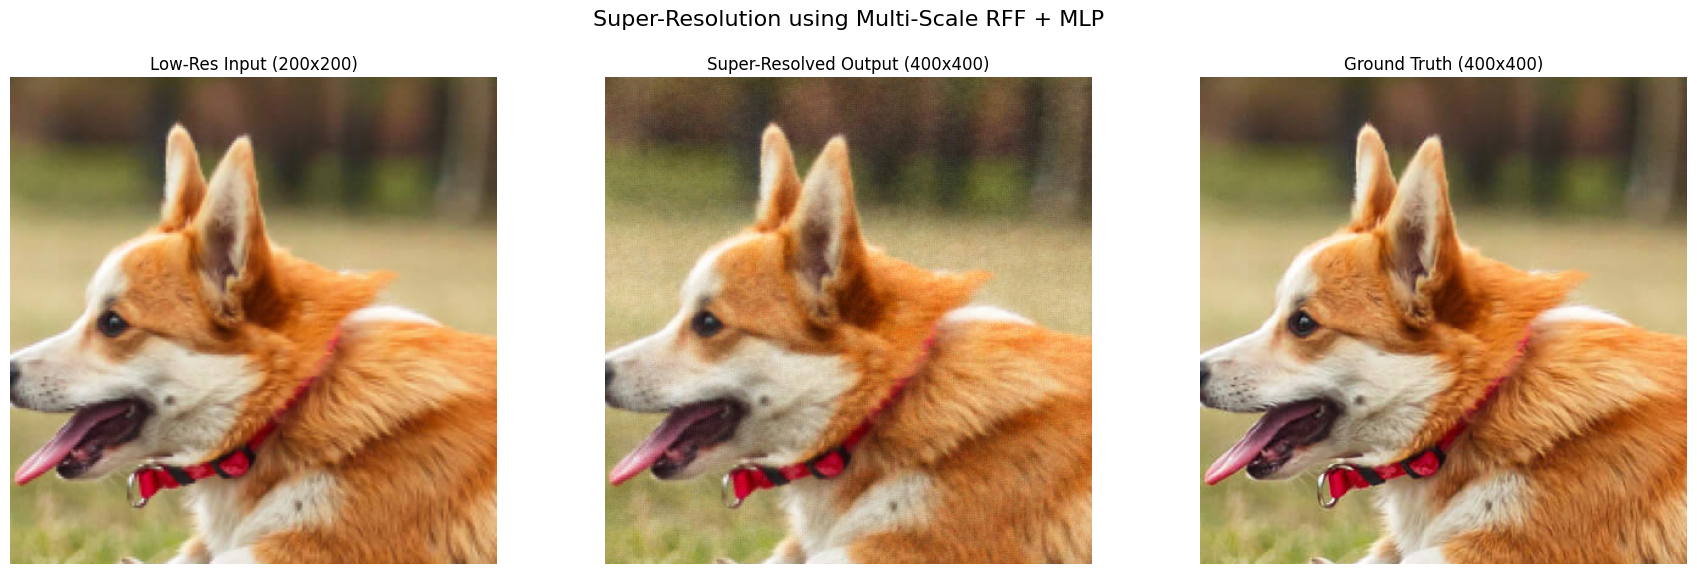

In [4]:
# --- 1. Prepare HR Inference Data ---
# Create a new, dense coordinate map for the target HR size
hr_coords = create_coordinate_map(hr_ground_truth.shape[1], hr_ground_truth.shape[2], device)

# IMPORTANT: Apply the exact same RFF transformation using the same encoder object
print("Encoding HR image coordinates with the *same* encoder...")
hr_rff_features = rff_encoder.encode(hr_coords)

# --- 2. Predict the Super-Resolved Image ---
print("Performing inference to generate SR image...")
sr_model.eval()
with torch.no_grad():
    # The tanh output is in [-1, 1], so scale it back to [0, 1]
    predicted_hr_pixels = (sr_model(hr_rff_features) + 1) / 2

# Reshape the predicted pixels into the final HR image
super_resolved_image = predicted_hr_pixels.reshape(
    hr_ground_truth.shape[1], hr_ground_truth.shape[2], 3
).permute(2, 0, 1)

# --- 3. Evaluate and Visualize ---
rmse, psnr = calculate_image_metrics(hr_ground_truth, super_resolved_image)
print(f"\nSuper-Resolution Metrics -> RMSE: {rmse:.4f}, PSNR: {psnr:.2f} dB")

# Use our new plotting function for a 3-panel comparison
plot_super_resolution(lr_input_image, super_resolved_image, hr_ground_truth)

## 4. The State-of-the-Art Fix: SIREN (Sinusoidal Representation Network)

The MLP output was blurry due to its "spectral bias" towards low frequencies. To get truly sharp results, we need a different architecture. **SIREN** uses `sin(x)` as its activation function, which is perfectly suited for modeling the high-frequency details (like edges and textures) that the MLP failed to capture.

Crucially, SIREN does not need RFFs. It operates directly on the raw input coordinates, learning its own optimal feature representation.

Training SIREN model on LR data...


Training RFF Model: 100%|██████████| 5000/5000 [10:54<00:00,  7.64it/s, loss=0.000013]


Performing inference with SIREN to generate SR image...

SIREN Super-Resolution Metrics -> RMSE: 0.0166, PSNR: 35.59 dB


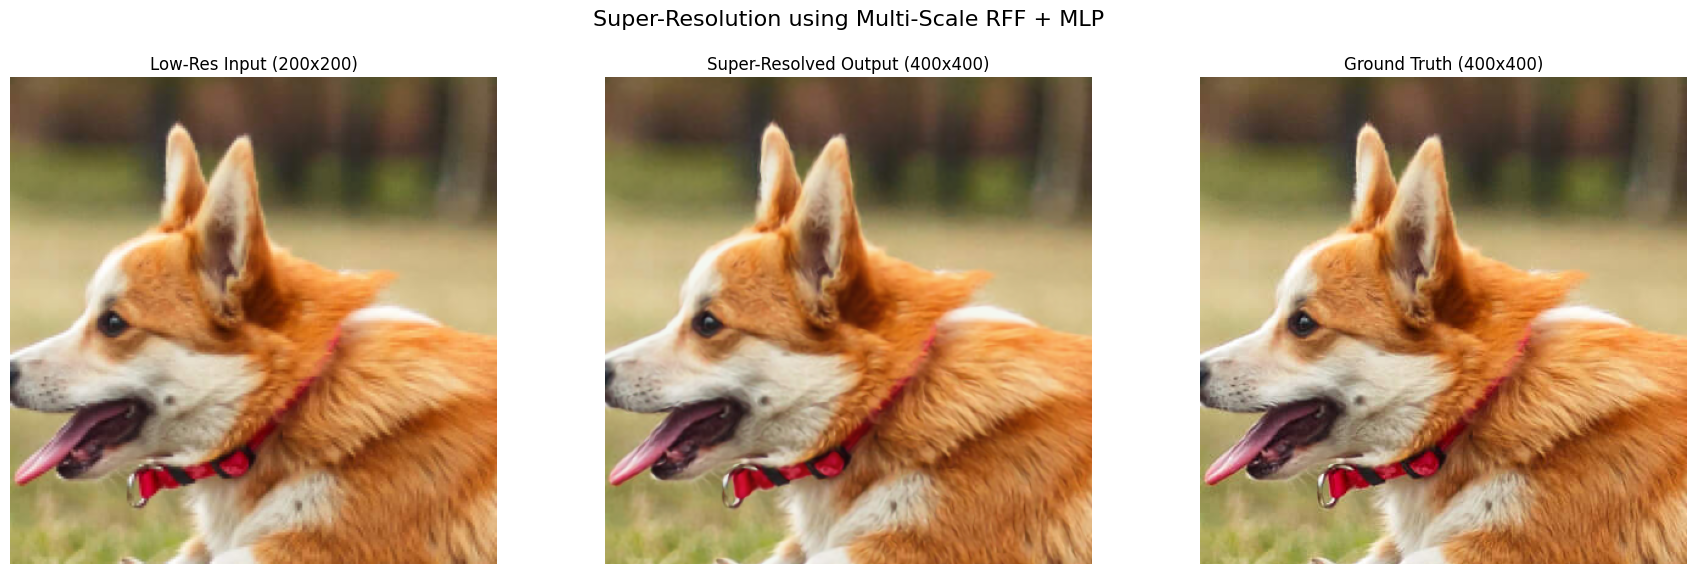

In [5]:
# --- 1. Import the new SIREN model ---
from models import SIREN

# --- 2. Define Hyperparameters for SIREN ---
SIREN_HIDDEN = 256
SIREN_LAYERS = 5
SIREN_EPOCHS = 5000  # SIREN can benefit from longer training
SIREN_LR = 5e-5      # SIREN often requires a slightly different learning rate

# --- 3. Create and Train the SIREN Model ---
# Note: We pass the raw low-resolution coordinates 'lr_coords' directly to the model.
# The target 'lr_pixels' are in the [0, 1] range, matching the model's final sigmoid output.
siren_model = SIREN(d_in=2, d_hidden=SIREN_HIDDEN, d_out=3, num_layers=SIREN_LAYERS).to(device)

print("Training SIREN model on LR data...")
train_rff_model(siren_model, lr_coords, lr_pixels, SIREN_EPOCHS, SIREN_LR, device)

# --- 4. Perform Inference with SIREN ---
print("Performing inference with SIREN to generate SR image...")
siren_model.eval()
with torch.no_grad():
    # Pass the raw high-resolution coordinates 'hr_coords' to the trained model
    predicted_siren_pixels = siren_model(hr_coords)

# Reshape the predicted pixels into the final HR image
super_resolved_siren_image = predicted_siren_pixels.reshape(
    hr_ground_truth.shape[1], hr_ground_truth.shape[2], 3
).permute(2, 0, 1)

# --- 5. Evaluate and Visualize SIREN's performance ---
rmse, psnr = calculate_image_metrics(hr_ground_truth, super_resolved_siren_image)
print(f"\nSIREN Super-Resolution Metrics -> RMSE: {rmse:.4f}, PSNR: {psnr:.2f} dB")

plot_super_resolution(lr_input_image, super_resolved_siren_image, hr_ground_truth)